Import all the needed modules

In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import ROOT as r
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
import multiprocessing

import time
from datetime import timedelta
from my_roc_auc3 import my_roc_auc
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

#Get total no of avaliable threads
nthreads = multiprocessing.cpu_count()

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++   -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.24/02
The scikit-learn version is 0.24.2.


Read in the coffea output as DF

In [7]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [2]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2016preVFP', '2016postVFP', '2018','2017']
var_dict = [{}, {}, {}]
df = []
for year in years:
  print(f'Processing {year}')
  result = load(f"../results/{year}/makeDF/output_WJet2.coffea")
  if isinstance(result,tuple):
      result = result[0]
  for varName in result:
    for i in range(3):
      if f'{i}jets' in varName:
        if varName.replace(f'_{i}jets','') in var_dict[i]:
          var_dict[i][varName.replace(f'_{i}jets','')] = np.append(var_dict[i][varName.replace(f'_{i}jets','')],result[varName].value)
        else:
          var_dict[i][varName.replace(f'_{i}jets','')] = result[varName].value
for i in range(3):
    df.append(pd.DataFrame(var_dict[i]))


Processing 2016preVFP
Processing 2016postVFP
Processing 2018
Processing 2017


In [3]:
njet = 0
data = df[njet] #pd.read_parquet('../results/csv4BDT/out_1jets.parquet')
print ('finish loading Dataframes')
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))
print ('\nList of features in dataset:')
for col in data.columns:
    print(col)

finish loading Dataframes
Size of data: (2027225, 28)
Number of events: 2027225
Number of columns: 28

List of features in dataset:
opp_charge
is2016preVFP
is2016postVFP
is2017
is2018
sample
label
weight
njets
e_m_Mass
e_m_Mass_reso
e_m_Mass_ereso
e_m_Mass_mreso
lepCos
e_deltaE
m_deltapT
met
eEta
mEta
mpt_Per_e_m_Mass
ept_Per_e_m_Mass
empt
emEta
DeltaEta_e_m
DeltaR_e_m
DeltaPhi_e_met
DeltaPhi_m_met
DeltaPhi_em_met


Prepare training/testing samples

In [4]:
data_clean = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

data_cuts = data_clean[(data_clean['weight']!=0)&(data_clean['opp_charge']==1)&(data_clean['e_m_Mass']>115)&(data_clean['e_m_Mass']<135)&((data_clean['label']==1)|(data_clean['label']==0))]
data_vbf = data_cuts#[data_cuts['isVBFcat']==1]
data_vbf.loc[:, ('absweight')] = data_vbf['weight'].abs()
ogweight = data_vbf['absweight'].loc[data_vbf['label']==1].sum()
data_vbf['absweight'].loc[data_vbf['label']==1] /= data_vbf[data_vbf['label']==1]['e_m_Mass_reso']
#data_vbf['absweight'].loc[data_vbf['label']==1] /= np.exp(data_vbf[data_vbf['label']==1]['e_m_Mass_reso'])
#data_vbf['absweight'].loc[data_vbf['label']==1] *= ogweight/data_vbf[data_vbf['label']==1]['absweight'].sum()

# split data into X and y
X = data_vbf
Y = data_vbf['label']

# split data into train and tsest sets
seed = 123
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
#X_train_pos, X_test_pos, y_train_pos, y_test_pos = X_train[X_train['weight']>0], X_test[X_test['weight']>0], y_train[X_train['weight']>0], y_test[X_test['weight']>0]
X_train_pos, X_test_pos, y_train_pos, y_test_pos = X_train, X_test, y_train, y_test

#Rescale signal weight to bkg weight
total_bkg_train_weights = X_train_pos.loc[X_train_pos['label'] == 0]['absweight'].sum()
total_sig_train_weights = X_train_pos.loc[X_train_pos['label'] == 1]['absweight'].sum()
sig_to_bkg_ratio = total_bkg_train_weights/total_sig_train_weights
print('Total Bkg Training weights', 'Total Sig Training weights')
print(total_bkg_train_weights, total_sig_train_weights)
print(sig_to_bkg_ratio)
# print(X_train['sample'].plot.density())
# print(X_test['sample'].plot.density())

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Total Bkg Training weights Total Sig Training weights
7268.712144410615 7263.465215630419
1.000722372672606


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
feature_names = ['e_m_Mass', 'e_met_mT', 'm_met_mT', 'mpt_Per_e_m_Mass', 'ept_Per_e_m_Mass', 'empt', 'met', 'DeltaEta_e_m', 'pZeta85']
vif_data = pd.DataFrame()
vif_data["feature"] = data_vbf[feature_names].columns
vif_data["VIF"] = [variance_inflation_factor(data_vbf[feature_names].values, i) for i in range(len(data_vbf[feature_names].columns))]
print(vif_data)

            feature         VIF
0          e_m_Mass  319.208786
1          e_met_mT   32.472171
2          m_met_mT   29.708254
3  mpt_Per_e_m_Mass   81.307250
4  ept_Per_e_m_Mass   81.467899
5              empt   12.561193
6               met   30.236315
7      DeltaEta_e_m   21.283029
8           pZeta85    2.914122


In [27]:
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        print(feature_names[i], feature_names[j], corr(data_vbf[feature_names[i]], data_vbf[feature_names[j]], data_vbf['weight']))

e_m_Mass e_met_mT 0.044791925714578136
e_m_Mass m_met_mT 0.028519221722142735
e_m_Mass mpt_Per_e_m_Mass -0.03966539386773872
e_m_Mass ept_Per_e_m_Mass -0.013573607747469704
e_m_Mass empt 0.035169008547696036
e_m_Mass met 0.03051874732376339
e_m_Mass DeltaEta_e_m 0.03698337847119958
e_m_Mass pZeta85 -0.013395791514329663
e_met_mT m_met_mT -0.036398623767585514
e_met_mT mpt_Per_e_m_Mass -0.20846323352691778
e_met_mT ept_Per_e_m_Mass 0.49769176863878734
e_met_mT empt 0.447406674511597
e_met_mT met 0.6567895348154479
e_met_mT DeltaEta_e_m -0.061036068328789085
e_met_mT pZeta85 -0.43709546801255644
m_met_mT mpt_Per_e_m_Mass 0.49769040829230876
m_met_mT ept_Per_e_m_Mass -0.201038433502893
m_met_mT empt 0.4805702064973746
m_met_mT met 0.6238592121887655
m_met_mT DeltaEta_e_m -0.04248732119338581
m_met_mT pZeta85 -0.46191226357882675
mpt_Per_e_m_Mass ept_Per_e_m_Mass -0.23668401158990268
mpt_Per_e_m_Mass empt 0.2378808306322919
mpt_Per_e_m_Mass met 0.11444102365220715
mpt_Per_e_m_Mass DeltaEta

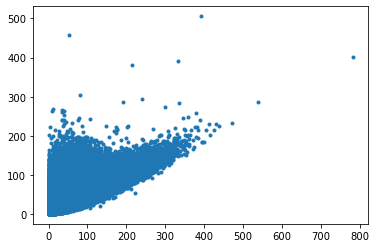

In [32]:
plt.plot('m_met_mT','met','.',data=data_vbf)

In [5]:
feature_names = ['met', 'DeltaEta_e_m', 'empt', 'DeltaPhi_em_met']#, 'e_met_mT', 'm_met_mT', 'mpt_Per_e_m_Mass', 'ept_Per_e_m_Mass']
#feature_names = ['met', 'DeltaEta_e_m', 'empt', 'DeltaPhi_em_met', 'j1pt', 'j1Eta', 'DeltaEta_j1_em']
#feature_names = ['Ht_had', 'Rpt', 'DeltaEta_j1_j2', 'j1_j2_mass', 'j2pt', 'pt_cen_Deltapt', 'DeltaEta_em_j1j2', 'j1pt', 'empt', 'met', 'DeltaEta_e_m']
#feature_names = ['Zeppenfeld_DeltaEta', 'Ht_had', 'Rpt', 'DeltaEta_j1_j2', 'j1_j2_mass', 'j2pt', 'pt_cen_Deltapt', 'j1pt', 'empt', 'met', 'DeltaEta_e_m'] 

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Time spent on training 0:00:32.970394
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=64, num_parallel_tree=1,
              random_state=123, reg_alpha=20, reg_lambda=30,
              scale_pos_weight=1.000722372672606, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


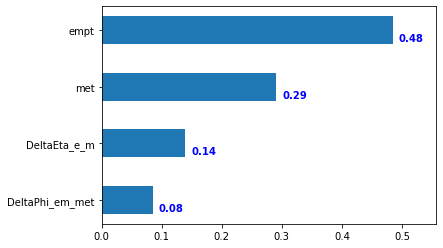

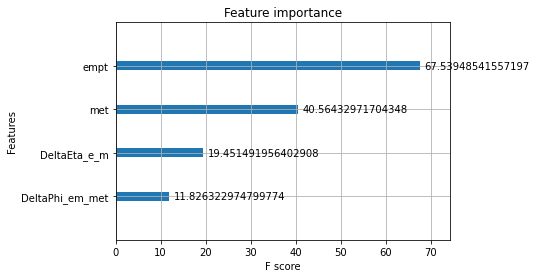

AUC of training set: 0.836684
AUC of testing set: 0.828386
Difference: 0.50


In [6]:
# Train with the default model to select features
tic = time.time()
model = xgb.XGBClassifier(n_jobs=nthreads, objective='binary:logistic', scale_pos_weight=sig_to_bkg_ratio, max_depth=3, reg_lambda=30, reg_alpha=20, seed=123)#, reg_alpha=15)#, learning_rate=0.1)#reg_lambda=30, learning_rate=0.1, n_estimators=50)#max_depth=3, seed=123)
#model = xgb.XGBClassifier(n_jobs=nthreads, objective='binary:logistic', scale_pos_weight=sig_to_bkg_ratio, max_depth=3, reg_lambda=30, reg_alpha=20)#, learning_rate=0.1)#reg_lambda=30, learning_rate=0.1, n_estimators=50)#max_depth=3, seed=123)
#model = xgb.XGBClassifier(n_jobs=nthreads, objective='binary:logistic', scale_pos_weight=sig_to_bkg_ratio, max_depth=3, reg_lambda=30, reg_alpha=30)
#model = xgb.XGBClassifier(n_jobs=nthreads, objective='binary:logistic', scale_pos_weight=sig_to_bkg_ratio, max_depth=3, reg_lambda=30, reg_alpha=30)
model.fit(X_train_pos[feature_names], y_train_pos, early_stopping_rounds=10, sample_weight=X_train_pos['absweight'], eval_set = [(X_train_pos[feature_names], y_train_pos), (X_test_pos[feature_names], y_test_pos)], eval_metric='auc', sample_weight_eval_set = [X_train_pos['absweight'], X_test_pos['absweight']], verbose=False)
toc = time.time()
print("Time spent on training %s"%str(timedelta(seconds=toc - tic)))
print(model)

#Check the feature ranking
importances = model.feature_importances_
sorted_importance = [y for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
sorted_features = [x for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, height=0.5)
plt.xlim(0, max(sorted_importance)*1.15)
for i, v in enumerate(sorted_importance):
    plt.text(v+0.01, i-0.2, str(round(v,2)), color = 'blue', fontweight = 'bold')
plt.show()

xgb.plot_importance(model, importance_type="gain")
plt.show()

#Check also the auc
results = model.evals_result()
print ("AUC of training set: %f"%results['validation_0']['auc'][-1])
print ("AUC of testing set: %f"%results['validation_1']['auc'][-1])
print('Difference: %.2f'%((results['validation_0']['auc'][-1]-results['validation_1']['auc'][-1])*100/(results['validation_0']['auc'][-1]+results['validation_1']['auc'][-1])))

#Modify features in the cell above accordingly and run again

In [168]:
X_train['mva'] = model.predict_proba(X_train[feature_names])[:,1]
X_test['mva'] = model.predict_proba(X_test[feature_names])[:,1]
X['mva'] = model.predict_proba(X[feature_names])[:,1]
print('Train', my_roc_auc(y_train.to_numpy(), X_train['mva'].to_numpy(), X_train['weight'].to_numpy()))
print('Test', my_roc_auc(y_test.to_numpy(), X_test['mva'].to_numpy(), X_test['weight'].to_numpy()))
print('Overall', my_roc_auc(Y.to_numpy(), X['mva'].to_numpy(), X['weight'].to_numpy()))

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_1948955/2125479340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mva'] = model.predict_proba(X_train[feature_names])[:,1]
/tmp/ipykernel_1948955/2125479340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['m

Train 0.8278320183628273
Test 0.8298895720842435
Overall 0.8284478514893491


Overtraining test

In [7]:
catcatcat2 = 'GG cat, 0 jets'#['GG cat, 0 jets', 'GG cat, 1 jets', 'GG cat, $\geq$ 2 jets', 'VBF cat']
catcatcat = 'gg0'#['gg0', 'gg1', 'gg2', 'vbf']

In [8]:
import mplhep
import math

%matplotlib inline

from coffea import hist
df_test = X.loc[X_test.index, ['mva','label','weight']]
df_train = X.loc[X_train.index, ['mva','label','weight']]
df_test_bkg = df_test[df_test['label']==0]
df_train_bkg = df_train[df_train['label']==0]
df_test_signal = df_test[df_test['label']==1]
df_train_signal = df_train[df_train['label']==1]

binning = 50
og_bin = hist.Bin('MVA', 'BDT Discriminator', binning, 0., 1.).edges()

h = hist.Hist('A.U.', hist.Bin('MVA', 'BDT Discriminator', binning, 0., 1.), hist.Cat("sample", "sample"))
h.fill(MVA=df_test_bkg['mva'].to_numpy(), sample='Bkg Testing Samples', weight=df_test_bkg['weight'].to_numpy())
h.fill(MVA=df_test_signal['mva'].to_numpy(), sample='Signal Testing Samples', weight=df_test_signal['weight'].to_numpy())
h.fill(MVA=df_train_bkg['mva'].to_numpy(), sample='Bkg Training Samples', weight=df_train_bkg['weight'].to_numpy())
h.fill(MVA=df_train_signal['mva'].to_numpy(), sample='Signal Training Samples', weight=df_train_signal['weight'].to_numpy())

import uproot3
root_file = uproot3.recreate("Overtraining.root")

for sample in ['Bkg Testing Samples', 'Signal Testing Samples', 'Bkg Training Samples', 'Signal Training Samples']:
    root_file[sample] = hist.export1d(h.integrate('sample', sample))

f_in = r.TFile('Overtraining.root')
f_in.ls()
h_test_bkg_root = f_in.Get('Bkg Testing Samples')
h_train_bkg_root = f_in.Get('Bkg Training Samples')
h_test_sig_root = f_in.Get('Signal Testing Samples')
h_train_sig_root = f_in.Get('Signal Training Samples')

list_of_hist = [h_test_bkg_root, h_train_bkg_root, h_test_sig_root, h_train_sig_root]

import array
Binning = [array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])]

for j in range(len(list_of_hist)):
    prev_bin = 0
    for i in range(1,len(og_bin)):
        effCon = ((list_of_hist[j].GetBinContent(i)**2)/(list_of_hist[j].GetBinError(i)**2)) if list_of_hist[j].GetBinError(i) != 0 else 0
        if (effCon+prev_bin) > 10:
            prev_bin=0
            Binning[j].append(og_bin[i])
        else:
            prev_bin+=effCon
    if Binning[j][-1]!=1: Binning[j].append(1)

if len(Binning[0]) < len(Binning[1]):
    Binning[1] = array.array('d', [p for p in Binning[0]])
else:
    Binning[0] = array.array('d', [p for p in Binning[1]])
if len(Binning[2]) < len(Binning[3]):
    Binning[3] = array.array('d', [p for p in Binning[2]])
else:
    Binning[2] = array.array('d', [p for p in Binning[3]])

for j in range(len(list_of_hist)):
    list_of_hist[j] = list_of_hist[j].Rebin(len(Binning[j])-1, "", Binning[j])

for c in range(1):
    for j in range(len(list_of_hist)):
        poping_list = []
        for i in range(1,list_of_hist[j].GetNbinsX()+1):
            effCon = ((list_of_hist[j].GetBinContent(i)**2)/(list_of_hist[j].GetBinError(i)**2)) if list_of_hist[j].GetBinError(i) != 0 else 0
            if effCon == 0: continue
            if effCon < 10:
                poping_list.append(i-1)
        Binning[j] = array.array('d', [Binning[j][e] for e in range(len(Binning[j])) if not e in poping_list]) 
        if Binning[j][-1]!=1: Binning[j].append(1)

    if len(Binning[0]) < len(Binning[1]):
        Binning[1] = array.array('d', [p for p in Binning[0]])
    else:
        Binning[0] = array.array('d', [p for p in Binning[1]])
    if len(Binning[2]) < len(Binning[3]):
        Binning[3] = array.array('d', [p for p in Binning[2]])
    else:
        Binning[2] = array.array('d', [p for p in Binning[3]])

    for j in range(len(list_of_hist)):
        list_of_hist[j] = list_of_hist[j].Rebin(len(Binning[j])-1, "", Binning[j])
    for j in range(len(list_of_hist)):
        for i in range(1,list_of_hist[j].GetNbinsX()+1):
            effCon = ((list_of_hist[j].GetBinContent(i)**2)/(list_of_hist[j].GetBinError(i)**2)) if list_of_hist[j].GetBinError(i) != 0 else 0

#print(Binning1, Binning2)

p_bkg = list_of_hist[0].Chi2Test(list_of_hist[1], 'WWP')
p_sig = list_of_hist[2].Chi2Test(list_of_hist[3], 'WWP')

print(p_bkg)
print(p_sig)

scales = {
    'Bkg Testing Samples': 1/np.sum(df_test_bkg['weight'].to_numpy()),
    'Signal Testing Samples': 1/np.sum(df_test_signal['weight'].to_numpy()),
    'Bkg Training Samples': 1/np.sum(df_train_bkg['weight'].to_numpy()),
    'Signal Training Samples': 1/np.sum(df_train_signal['weight'].to_numpy()),
}

h.scale(scales, axis='sample')

plt.style.use(mplhep.style.CMS)

plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

#For ratio plots
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12,12),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.08)

# fig = plt.figure(
#         figsize=(12,12),
#       )
# ax = plt.axes()

from cycler import cycler
colors = ['#1f78b4','#33a02c']
ax.set_prop_cycle(cycler(color=colors))

#np.array(Binning1)
hist.plot1d(h[:, ['Bkg Testing Samples']].rebin("MVA", hist.Bin("MVA", "rebinned MVA", np.array(Binning[0]))), ax=ax, clear=False) 
hist.plot1d(h[:, ['Signal Testing Samples']].rebin("MVA", hist.Bin("MVA", "rebinned MVA", np.array(Binning[2]))), ax=ax, clear=False) #density=True, 
#print(fig[-1].get_color())

#For ratio plots
facecolor = {'Signal': ['#33a02c', 'r'], 'Bkg': ['#1f78b4', 'k']}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'elinewidth': 1,
}
denom_fill_opts = {
    'alpha': 0.3, 
    'hatch': '///'
}

error_opts = {
    'label': '',
    'hatch': '///',
    'alpha': 0.3,
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}

fill_opts = {
    'edgecolor': (0,0,0,0.3), 
    'alpha': 0.2, 
}


for fc, bin12 in zip(facecolor, [Binning[2], Binning[0]]):
    error_opts['facecolor'] = facecolor[fc][1]
    fill_opts['facecolor'] = facecolor[fc][1]
    hist.plot1d(
        h[:, f'{fc} Training Samples'].rebin("MVA", hist.Bin("MVA", "rebinned MVA", np.array(bin12))),
        ax=ax,
        overlay='sample',
        stack=True,
        clear=False,
        fill_opts=fill_opts,
        error_opts=error_opts,
    )
    data_err_opts['color'] = facecolor[fc][0]
    denom_fill_opts['color'] = facecolor[fc][1]
    hist.plotratio(
        num=h.integrate('sample', f'{fc} Testing Samples').rebin("MVA", hist.Bin("BDT Discriminator", "BDT Discriminator", np.array(bin12))),
        denom=h.integrate('sample', f'{fc} Training Samples').rebin("MVA", hist.Bin("BDT Discriminator", "BDT Discriminator", np.array(bin12))),
        ax=rax,
        error_opts=data_err_opts,
        denom_fill_opts=denom_fill_opts,
        guide_opts={},
        unc='num',
        clear=False
    )


ax.set_yscale('log')
ax.set_ylim(10**(math.log10(min([i for i in sorted(h[:, 'Bkg Training Samples'].values()[('Bkg Training Samples',)]) if i!=0]))-1), 10**(math.log10(h[:, 'Bkg Training Samples'].values()[('Bkg Training Samples',)].max()+0.5)))
#ax.set_ylim(0.000001, 10**(math.ceil(math.log10(h[:, 'Bkg Training Samples'].sum("MVA").values()[('Bkg Training Samples',)]))+1))
#ax.set_ylim(0, 10**5)
ax.set_xlabel(None)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, ncol=2, loc=9, title=f'{catcatcat2}; $\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})')

rax.set_xlim(0, 1)
rax.set_ylim(0, 2)
rax.set_ylabel("Test/Train", loc='center')

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
#fig.savefig(f'plots/BDTValid/{catcatcat}_overtrain.png')

KeyError: "['mva'] not in index"

In [60]:
#Save model if everything looks good
model_out_file = "results/model_VBF_2jets.json"
model.save_model(model_out_file)

Check mass-independence of MVA quantiles

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_485972/3129890460.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sig['mva'] = model.predict_proba(data_sig[feature_names])[:,1]


[0.         0.57831174 0.72070009 0.81771088 1.001     ]
3576.950972640012
3576.3462803651664
3574.3120445453396
3580.2097467082044


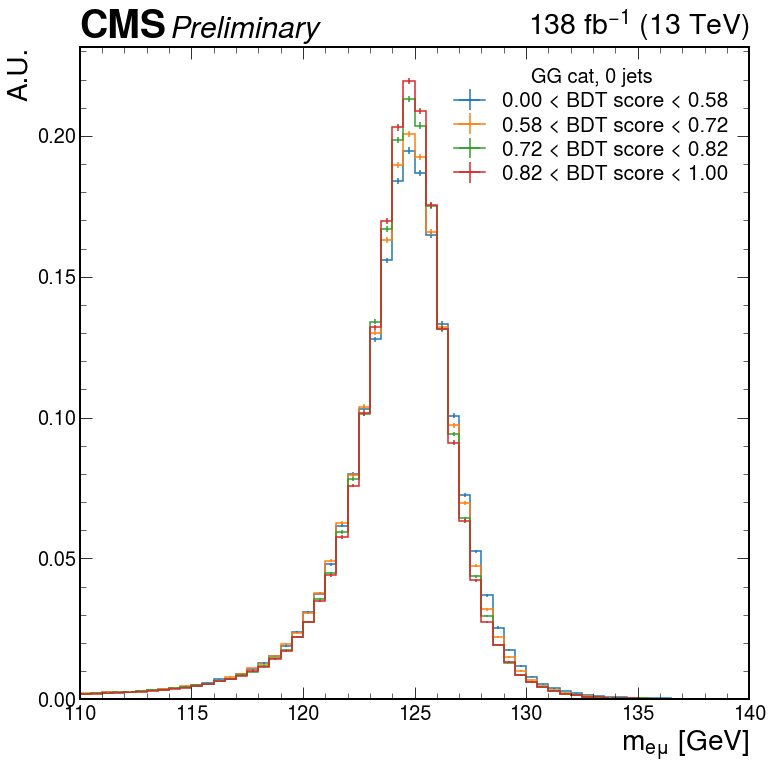

In [11]:
from coffea import hist

#Get the signal
data_sig = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)]#&(data_clean['isVBFcat']==0)]
data_sig['mva'] = model.predict_proba(data_sig[feature_names])[:,1]

#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW
wq = DescrStatsW(data=data_sig['mva'], weights=data_sig['weight'])
#quantiles = wq.quantile(probs=np.array([0, 0.1, 0.2, 0.3, 0.40, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), return_pandas=False)
#quantiles = wq.quantile(probs=np.array([0, 0.20, 0.40, 0.60, 0.80, 1]), return_pandas=False)
quantiles = wq.quantile(probs=np.array([0, 0.25, 0.50, 0.75, 1]), return_pandas=False)
#Fill in sliced invariant mass according to MVA quantiles
h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 60, 110, 140), hist.Cat("sample", "sample"))
#scales = {}
#quantiles = [0,0.25,0.5,0.75,1]
quantiles[0] = 0
quantiles[-1] = 1.001
print(quantiles)
for i in range(len(quantiles)-1):
    quant25 = data_sig[(data_sig['mva']<quantiles[i+1])&(data_sig['mva']>=quantiles[i])]
    print(quant25['weight'].sum())
    label = f'{quantiles[i]:.2f} < BDT score < {quantiles[i+1]:.2f}'
    h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())
    #scales[label] = 1/np.sum(quant25['weight'].to_numpy())

#h_quan.scale(scales, axis='sample')

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

fig = plt.figure(
        figsize=(12,12),
      )

ax = hist.plot1d(h_quan, density=True)
#ax.set_ylim(0, 0.05)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, title=catcatcat2)

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
#fig.savefig(f'plots/BDTValid/{catcatcat}_sig.png')





/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_332790/3877908643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bkg['mva'] = model.predict_proba(data_bkg[feature_names])[:,1]


[0.         0.12440422 0.16233413 0.43615282 1.001     ]
1446.44431339893
363.3507042683435
359.79675043120574
360.6877503011357
362.6091083982451


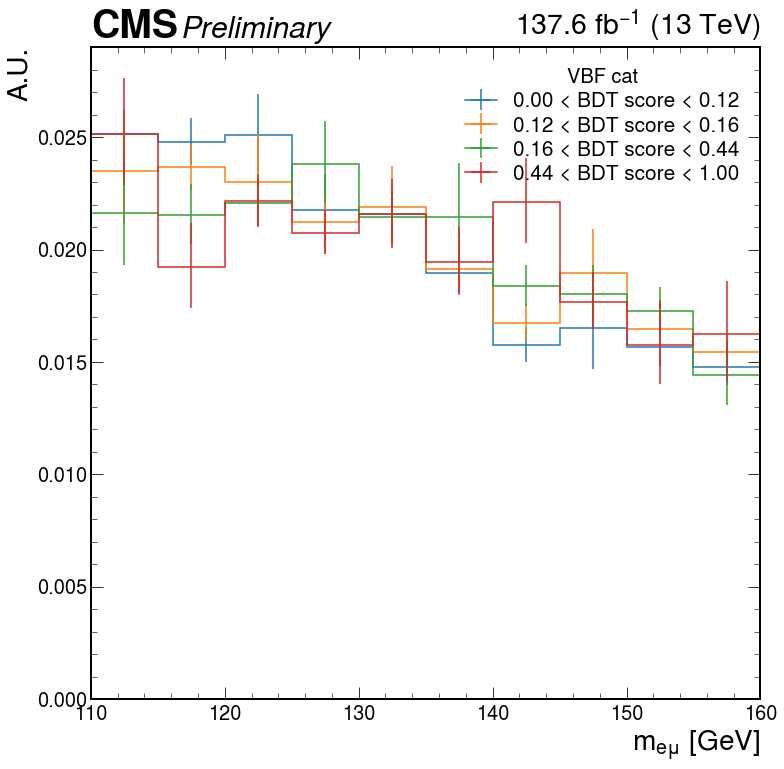

In [105]:
from coffea import hist

#Get the background
data_bkg = data_clean[(data_clean['label']==0)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]
data_bkg['mva'] = model.predict_proba(data_bkg[feature_names])[:,1]

#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW
wq = DescrStatsW(data=data_bkg['mva'], weights=data_bkg['weight'])
#quantiles = wq.quantile(probs=np.array([0, 0.20, 0.40, 0.60, 0.80, 1]), return_pandas=False)
quantiles = wq.quantile(probs=np.array([0, 0.25, 0.50, 0.75, 1]), return_pandas=False)
#quantiles = wq.quantile(probs=np.array([0, 0.25, 1]), return_pandas=False)
#Fill in sliced invariant mass according to MVA quantiles
h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 10, 110, 160), hist.Cat("sample", "sample"))
#scales = {}
quantiles[0] = 0
quantiles[-1] = 1.001
quantiles[1]+=0.001
print(quantiles)
print(data_bkg['weight'].sum())
for i in range(len(quantiles)-1):
    quant25 = data_bkg[(data_bkg['mva']<quantiles[i+1])&(data_bkg['mva']>=quantiles[i])]
    print(quant25['weight'].sum())
    label = f'{quantiles[i]:.2f} < BDT score < {quantiles[i+1]:.2f}'
    h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())
    #scales[label] = 1/np.sum(quant25['weight'].to_numpy())

#h_quan.scale(scales, axis='sample')

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

fig = plt.figure(
        figsize=(12,12),
      )

ax = hist.plot1d(h_quan, density=True)
#ax.set_ylim(0, 0.05)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, title=catcatcat2)

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
fig.savefig(f'plots/BDTValid/{catcatcat}_bkg.png')
# plt.text(0.5, 15, f'$\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})', 
#          fontsize=20,
#          horizontalalignment='center',
#          verticalalignment='top')




Check Invariance of 120 and 130 Samples

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_332790/3588860143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_125['mva'] = model.predict_proba(data_125[feature_names])[:,1]
/tmp/ipykernel_332790/3588860143.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_120[

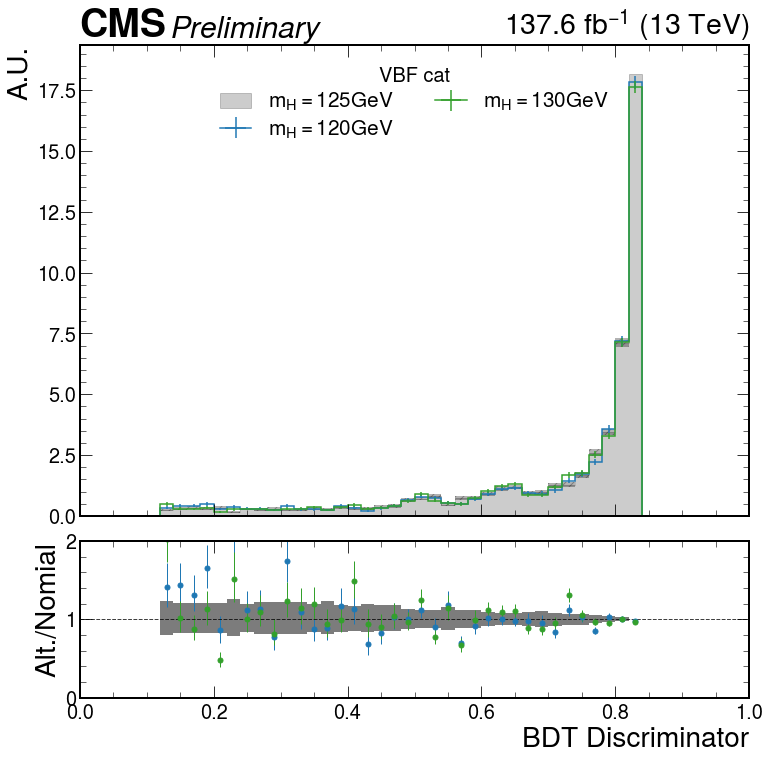

In [59]:
data_125 = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]
data_120 = data_clean[(data_clean['label']==120)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]
data_130 = data_clean[(data_clean['label']==130)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]

data_125['mva'] = model.predict_proba(data_125[feature_names])[:,1]
data_120['mva'] = model.predict_proba(data_120[feature_names])[:,1]
data_130['mva'] = model.predict_proba(data_130[feature_names])[:,1]

binning = 50
h_mass = hist.Hist('A.U.', hist.Bin('MVA', 'BDT Discriminator', binning, 0, 1), hist.Cat("sample", "sample"))

h_mass.fill(MVA=data_125['mva'].to_numpy(), sample='$m_{H}=125$GeV', weight=data_125['weight'].to_numpy())
h_mass.fill(MVA=data_130['mva'].to_numpy(), sample='$m_{H}=130$GeV', weight=data_130['weight'].to_numpy())
h_mass.fill(MVA=data_120['mva'].to_numpy(), sample='$m_{H}=120$GeV', weight=data_120['weight'].to_numpy())

scales = {
            '$m_{H}=125$GeV': binning/np.sum(data_125['weight'].to_numpy()),
            '$m_{H}=120$GeV': binning/np.sum(data_120['weight'].to_numpy()),
            '$m_{H}=130$GeV': binning/np.sum(data_130['weight'].to_numpy()),
        }

h_mass.scale(scales, axis='sample')

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

#For ratio plots
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12,12),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)

fig.subplots_adjust(hspace=.08)

error_opts = {
    'label': '',
    'hatch': '///',
    'facecolor': 'k',
    'alpha': 0.3,
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}

hist.plot1d(
    h_mass[:,'$m_{H}=125$GeV'],
    ax=ax,
    overlay='sample',
    stack=True,
    clear=False,
    fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.2, 'facecolor': 'k'},
    error_opts=error_opts,
)

from cycler import cycler
colors = ['#1f78b4','#33a02c']
ax.set_prop_cycle(cycler(color=colors))

hist.plot1d(h_mass[:,['$m_{H}=120$GeV', '$m_{H}=130$GeV']], ax=ax, clear=False)
ax.set_xlabel(None)

leg = ax.legend(fontsize='x-small', labelspacing=0.25, ncol=2, loc=9, title=catcatcat2)

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#33a02c',
            'elinewidth': 1,
        }


data_err_opts2 = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#1f78b4',
            'elinewidth': 1,
        }

hist.plotratio(
    num=h_mass[:,'$m_{H}=120$GeV'].sum('sample'),
    denom=h_mass[:,'$m_{H}=125$GeV'].sum('sample'),
    ax=rax,
    error_opts=data_err_opts2,
    denom_fill_opts={},
    guide_opts={},
    unc='num',
    clear=False
)

hist.plotratio(
    num=h_mass[:,'$m_{H}=130$GeV'].sum('sample'),
    denom=h_mass[:,'$m_{H}=125$GeV'].sum('sample'),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num',
    clear=False
)

rax.set_xlim(0, 1)
rax.set_ylim(0, 2)
rax.set_ylabel("Alt./Nomial", loc='center')

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
fig.savefig(f'plots/BDTValid/{catcatcat}_sig.png')
# plt.text(0.5, 15, f'$\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})', 
#          fontsize=20,
#          horizontalalignment='center',
#          verticalalignment='top')


In [53]:
# Hyperparameter optimization using RandomizedSearchCV

#Setup self-defined auc calculated with the U-test probability interpretation

score_params = {"weights": X_train['weight']}

my_auc = make_scorer(my_roc_auc,
                     needs_proba=True, 
                     **score_params)

# params={
#  "learning_rate"    : [ 0.10, 0.15, 0.20, 0.25, 0.30 ],
#  "max_depth"        : [ 3, 4, 5, 6, 8],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.6, 0.7, 0.8, 0.9, 1.0 ],
#  "subsample"        : [ 0.6, 0.7, 0.8, 0.9, 1.0 ],
#  "reg_lambda"       : [ 0.1, 1.0, 5.0, 10.0 ],            
#  "reg_alpha "       : [ 0, 0.1, 1.0, 5.0 ],    
#  "n_estimators"     : [ 80, 100, 120, 150 ],
#  "scale_pos_weight" : [sig_to_bkg_ratio],   
# }

# a more conservative set for 0-jet events
params=[
{
 "learning_rate"    : [ 0.20 ],
 "max_depth"        : [ 2 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 10.0, 20.0 ],  
 "reg_alpha "       : [ 10.0, 20.0 ],
 "n_estimators"     : [ 120, 140 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
,
    
{
 "learning_rate"    : [ 0.25 ],
 "max_depth"        : [ 2 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 20.0, 30.0 ],  
 "reg_alpha "       : [ 20.0, 30.0 ],
 "n_estimators"     : [ 120, 140 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
,
    
{
 "learning_rate"    : [ 0.25 ] ,
 "max_depth"        : [ 3 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 20.0, 30.0 ],  
 "reg_alpha "       : [ 20.0, 30.0 ],
 "n_estimators"     : [ 80, 100 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
    
,

{
 "learning_rate"    : [ 0.30 ] ,
 "max_depth"        : [ 3 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 30.0 ],  
 "reg_alpha "       : [ 30.0 ],
 "n_estimators"     : [ 80, 100 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
    
,
    
{
 "learning_rate"    : [ 0.20, 0.25 ] ,
 "max_depth"        : [ 4 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 30.0 ],  
 "reg_alpha "       : [ 30.0 ],
 "n_estimators"     : [ 60, 80 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}

]
print params
model = xgb.XGBClassifier(n_jobs=nthreads, seed=123)
# use random_state=123 for reproducibility
random_search=GridSearchCV(model,param_grid=params, scoring=my_auc,n_jobs=nthreads,cv=3, verbose=3)
#random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring=my_auc,n_jobs=nthreads,cv=3, verbose=3)
tic = time.time()
random_search.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'])
toc = time.time()
print "Time spent on hyperparameter optimization %s"%str(timedelta(seconds=toc - tic))

[{'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.2], 'reg_alpha ': [10.0, 20.0], 'n_estimators': [120, 140], 'subsample': [0.5, 0.6], 'reg_lambda': [10.0, 20.0], 'max_depth': [2]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.25], 'reg_alpha ': [20.0, 30.0], 'n_estimators': [120, 140], 'subsample': [0.5, 0.6], 'reg_lambda': [20.0, 30.0], 'max_depth': [2]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.25], 'reg_alpha ': [20.0, 30.0], 'n_estimators': [80, 100], 'subsample': [0.5, 0.6], 'reg_lambda': [20.0, 30.0], 'max_depth': [3]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.3], 'reg_alpha ': [30.0], 'n_estimators': [80, 100], 'subsample': [0.5, 0.6], 'reg_lambda': [30.0], 'max_depth': [3]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.2, 0.25], 'reg_alpha ': [30.0], 'n_estimators': [60, 80], 'subsample': [0.5, 0.6], 'reg_lambda': [30.0], 'max_depth': [4]}]
Fitting 3 folds for each of 60 candidates, t

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed: 17.9min
[Parallel(n_jobs=24)]: Done 180 out of 180 | elapsed: 36.7min finished


Time spent on hyperparameter optimization 0:37:19.879179


In [54]:
random_search.cv_results_

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by d

{'mean_fit_time': array([ 75.05222726,  94.14709473, 111.47608829, 122.2682244 ,
        126.46650092, 175.71395334, 212.98633766, 235.32948033,
        265.53004297, 254.9572049 , 261.97513   , 263.56766661,
        232.23752546, 212.24572905, 222.96649639, 211.17968829,
        180.18426498, 156.78237669, 173.17228842, 147.42744366,
        161.95260628, 222.07015069, 218.80297438, 243.21379924,
        261.213082  , 258.78173629, 276.71754909, 279.05023305,
        242.87006672, 245.05637296, 240.65478039, 247.65560031,
        190.58787696, 202.74773033, 202.73168961, 216.1958069 ,
        229.254644  , 253.7029833 , 260.53535533, 205.65585041,
        265.31992141, 258.76058229, 283.59429328, 309.29582739,
        274.11249169, 262.2753586 , 266.26846695, 256.40840125,
        225.34203561, 224.48333232, 254.65684605, 238.67067607,
        212.01159064, 201.62991397, 277.34322627, 283.63284787,
        215.55982534, 241.48888334, 198.94639158, 157.68205031]),
 'mean_score_time': a

In [59]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=10, learning_rate=0.25,
       max_delta_step=0, max_depth=4, min_child_weight=7, missing=None,
       n_estimators=100, n_jobs=24, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_alpha =10.0, reg_lambda=20.0,
       scale_pos_weight=1.4643960793015485, seed=123, silent=True,
       subsample=0.7)

In [18]:
# Bayesian Optimization 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

score_params = {"weights": X_train['weight']}

#Setup self-defined auc calculated with the U-test probability interpretation
my_auc = make_scorer(my_roc_auc,
                     needs_proba=True, 
                     **score_params)

space={ 'max_depth': hp.quniform('max_depth', 3, 5, 1),
        'gamma': hp.quniform ('gamma', 0, 10, 1),
        'reg_alpha' : hp.quniform('reg_alpha', 0, 20, 1),
        'reg_lambda' : hp.quniform('reg_lambda', 0, 20, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 175, 1),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.8, 0.01),
        'subsample': hp.quniform('subsample', 0.6, 0.8, 0.01),
        'learning_rate': hp.quniform('learning_rate', 0.1, 0.3, 0.01),        
       }

def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), 
                              gamma=space['gamma'], reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'],
                              colsample_bytree=space['colsample_bytree'], subsample=space['subsample'],
                              learning_rate=space['learning_rate'],
                              scale_pos_weight=sig_to_bkg_ratio, n_jobs=24, early_stopping_rounds=10)
    auc = cross_val_score(estimator=model, X=X_train[feature_names], y=y_train, scoring=my_auc, n_jobs=nthreads, cv=3)
    CrossValMean = auc.mean()
    return {'loss': 1-CrossValMean, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print (best)

100%|██████████| 50/50 [1:10:47<00:00, 84.78s/it, best loss: 0.0965711873937]
{'reg_alpha': 6.0, 'colsample_bytree': 0.61, 'learning_rate': 0.21, 'n_estimators': 158.0, 'subsample': 0.73, 'reg_lambda': 10.0, 'max_depth': 5.0, 'gamma': 0.0}


In [24]:
print trials.trials

[{'refresh_time': datetime.datetime(2021, 7, 14, 19, 29, 45, 67000), 'book_time': datetime.datetime(2021, 7, 14, 19, 28, 54, 761000), 'misc': {'tid': 0, 'idxs': {'reg_alpha': [0], 'colsample_bytree': [0], 'learning_rate': [0], 'n_estimators': [0], 'subsample': [0], 'reg_lambda': [0], 'max_depth': [0], 'gamma': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'reg_alpha': [12.0], 'colsample_bytree': [0.72], 'learning_rate': [0.17], 'n_estimators': [124.0], 'subsample': [0.65], 'reg_lambda': [10.0], 'max_depth': [3.0], 'gamma': [1.0]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 0.09886820563143628, 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.72, early_stopping_rounds=10, gamma=1.0,
       learning_rate=0.17, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=124, n_jobs=24,
       nthread=None, objective='binary:logist

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.61, early_stopping_rounds=10, gamma=0.0,
       learning_rate=0.21, max_delta_step=0, max_depth=5, maximize=True,
       min_child_weight=1, missing=None, n_estimators=158, n_jobs=24,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=6.0, reg_lambda=10.0, scale_pos_weight=3.151886734544248,
       seed=123, silent=True, subsample=0.73)
Time spent on training 0:01:21.666210
AUC of training set: 0.925023
AUC of testing set: 0.912580


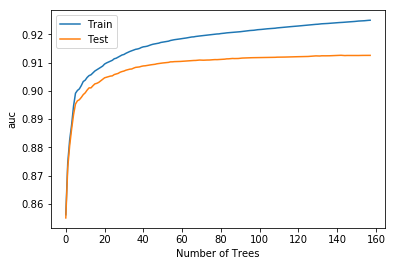

In [20]:
# Retrain with the best model
# Use seed=123 for reproducibility
tic = time.time()
#0 jets
# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=10, learning_rate=0.25,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=150, n_jobs=24, nthread=None,
#        objective='binary:logistic', random_state=0,
#        reg_alpha =5.0, reg_lambda=10.0,
#        scale_pos_weight=1.4643960793015485, seed=123, silent=True,
#        subsample=0.7)
#1 jets
# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=5, learning_rate=0.28,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=175, n_jobs=24, nthread=None,
#        objective='binary:logistic', random_state=0,
#        reg_alpha = 0.0, reg_lambda=1.0,
#        scale_pos_weight=sig_to_bkg_ratio, seed=123, silent=True,
#        subsample=0.7)

# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=4, learning_rate=0.1,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=150, n_jobs=24, nthread=None,random_state=0,
#        reg_alpha = 5.0, reg_lambda=10.0, objective='binary:logistic',
#        scale_pos_weight=sig_to_bkg_ratio, seed=123, silent=True,
#        subsample=0.7)
import math
params = {'reg_alpha': 6.0, 'colsample_bytree': 0.61, 'learning_rate': 0.21, 'n_estimators': 158, 'subsample': 0.73, 'reg_lambda': 10.0, 'max_depth': 5, 'gamma': 0.0}
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', n_jobs=24, nthread=None, random_state=0,
        objective='binary:logistic', scale_pos_weight=sig_to_bkg_ratio, early_stopping_rounds = 10, maximize = True, seed=123, silent=True)
model.set_params(**params)
# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=4, learning_rate=0.1,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=150, n_jobs=24, nthread=None,random_state=0,
#        reg_alpha = 5.0, reg_lambda=10.0, objective='binary:logistic',
#        scale_pos_weight=5*sig_to_bkg_ratio, seed=123, silent=True,
#        subsample=0.8)
print model
model.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'], eval_set = [(X_train[feature_names], y_train), (X_test[feature_names], y_test)], eval_metric='auc', sample_weight_eval_set = [X_train['weight'], X_test['weight']], verbose=False)
toc = time.time()
print "Time spent on training %s"%str(timedelta(seconds=toc - tic))

#Get AUC of final model for both training and testing set to avoid overtraining
results = model.evals_result()
print "AUC of training set: %f"%results['validation_0']['auc'][-1]
print "AUC of testing set: %f"%results['validation_1']['auc'][-1]

epochs = len(results['validation_0']['auc'])
x_axis = range(epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.xlabel('Number of Trees')
plt.show()

# Alternative way to get AUC
# train = xgb.DMatrix(data=X_train[feature_names],label=X_train.label.cat.codes,
#                    feature_names=feature_names, weight=X_train['weight'])
# test = xgb.DMatrix(data=X_test[feature_names],label=X_test.label.cat.codes,
#                    feature_names=feature_names, weight=X_test['weight'])
# booster = model.get_booster()
# print(booster.eval(test))
# print(booster.eval(train))

#sklearn auc does not work on negative weights
#y_pred = model.predict_proba(X_test[feature_names])
#print roc_auc_score(y_test, y_pred[:,1], sample_weight=X_test['weight'])

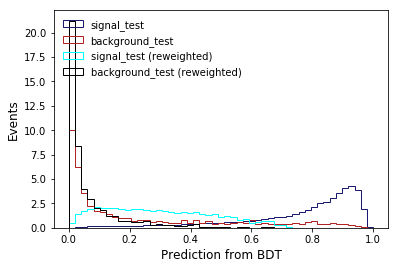

In [17]:
# plot signal and background separately
predictions_sig_test = model.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test = model.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])
predictions_sig_test2 = model2.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test2 = model2.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])
plt.figure();
weights_sig_test = X_test.loc[X_test['label'] == 1]['weight']
weights_bkg_test = X_test.loc[X_test['label'] == 0]['weight']
weights_sig_train = X_train.loc[X_train['label'] == 1]['weight']
weights_bkg_train = X_train.loc[X_train['label'] == 0]['weight']
plt.hist(predictions_sig_test2[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal_test', weights=weights_sig_test);
plt.hist(predictions_bkg_test2[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background_test', weights=weights_bkg_test);
plt.hist(predictions_sig_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='cyan',label='signal_test (reweighted)', weights=weights_sig_test);
plt.hist(predictions_bkg_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='black',label='background_test (reweighted)', weights=weights_bkg_test);
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False, loc = 2);

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in divide


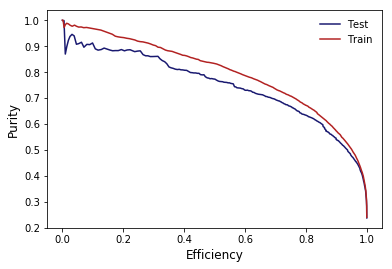

In [21]:
#Additional overtraining test
cuts = np.linspace(0,1,500);
#testing set
nsignal_test = np.zeros(len(cuts));
nbackground_test = np.zeros(len(cuts));
#Get predictions from trained mode
predictions_sig_test = model.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test = model.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])

predictions_sig_train = model.predict_proba(X_train.loc[X_train['label'] == 1][feature_names])
predictions_bkg_train = model.predict_proba(X_train.loc[X_train['label'] == 0][feature_names])

weights_sig_test = X_test.loc[X_test['label'] == 1]['weight'].to_numpy()
weights_bkg_test = X_test.loc[X_test['label'] == 0]['weight'].to_numpy()
weights_sig_train = X_train.loc[X_train['label'] == 1]['weight'].to_numpy()
weights_bkg_train = X_train.loc[X_train['label'] == 0]['weight'].to_numpy()

# weights_sig_test[weights_sig_test<0] = 0
# weights_bkg_test[weights_bkg_test<0] = 0
# weights_sig_train[weights_sig_train<0] = 0
# weights_bkg_train[weights_bkg_train<0] = 0

for i,cut in enumerate(cuts):
    sig_loc = np.where(predictions_sig_test[:,1] > cut)[0]
    bkg_loc = np.where(predictions_bkg_test[:,1] > cut)[0]
    nsignal_test[i] = weights_sig_test[sig_loc].sum()
    nbackground_test[i] = weights_bkg_test[bkg_loc].sum()
# unweighted
#     nsignal_test[i] = len(np.where(predictions_sig_test[:,1] > cut)[0]);
#     nbackground_test[i] = len(np.where(predictions_bkg_test[:,1] > cut)[0]);

#training set
nsignal_train = np.zeros(len(cuts));
nbackground_train = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    sig_loc = np.where(predictions_sig_train[:,1] > cut)[0]
    bkg_loc = np.where(predictions_bkg_train[:,1] > cut)[0]
    nsignal_train[i] = weights_sig_train[sig_loc].sum()
    nbackground_train[i] = weights_bkg_train[bkg_loc].sum()
# unweighted
#     nsignal_train[i] = len(np.where(predictions_sig_train[:,1] > cut)[0]);
#     nbackground_train[i] = len(np.where(predictions_bkg_train[:,1] > cut)[0]);
# plot efficiency vs. purity (ROC curve)
plt.figure();
purity_test = nsignal_test/(nsignal_test + nbackground_test)
purity_train = nsignal_train/(nsignal_train + nbackground_train)
purity_test[np.isnan(purity_test)] = 1
purity_train[np.isnan(purity_train)] = 1

plt.plot(nsignal_test/weights_sig_test.sum(), purity_test,'-',color='midnightblue', label='Test');
plt.plot(nsignal_train/weights_sig_train.sum(), purity_train,'-',color='firebrick', label='Train');

# unweighted
# plt.plot(nsignal_test/len(X_test[X_test.label == 1]), nsignal_test/(nsignal_test + nbackground_test),'-',color='midnightblue', label='Test');
# plt.plot(nsignal_train/len(X_train[X_train.label == 1]),nsignal_train/(nsignal_train + nbackground_train),'-',color='firebrick', label='Train');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

In [ ]:
#Check the feature ranking again with the best model

importances = model.feature_importances_
sorted_importance = [y for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
sorted_features = [x for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, height=0.5)
plt.xlim(0, max(sorted_importance)*1.15)
for i, v in enumerate(sorted_importance):
 plt.text(v+0.01, i-0.2, str(round(v,2)), color = 'blue', fontweight = 'bold')
plt.show()

xgb.plot_importance(model, importance_type="gain")
plt.show()

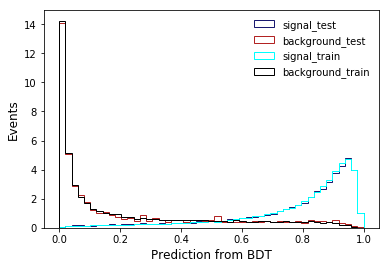

In [22]:
# plot signal and background separately
plt.figure();
plt.hist(predictions_sig_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal_test', weights=weights_sig_test);
plt.hist(predictions_bkg_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background_test', weights=weights_bkg_test);
plt.hist(predictions_sig_train[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='cyan',label='signal_train', weights=weights_sig_train);
plt.hist(predictions_bkg_train[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='black',label='background_train', weights=weights_bkg_train);
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

In [12]:
#Save model if everything looks good
model_out_file = "model_GG_2jets.json"
model.save_model(model_out_file)

In [14]:
#Load and predict from model
model_load = xgb.XGBClassifier()
model_load.load_model(model_out_file)
predictions = model_load.predict_proba(X_test[feature_names])
print predictions

[[0.11725003 0.88275   ]
 [0.97172993 0.02827005]
 [0.9947172  0.00528282]
 ...
 [0.05969727 0.9403027 ]
 [0.91208166 0.08791832]
 [0.97825897 0.02174105]]


ModuleNotFoundError: No module named 'ROOT'